## RF de MC y Reales

En este cuaderno vamos a entrenar varios RF:
  
1. Primero vamos a entrenar un RF con datos de simulaciones y vamos a ver cómo predice las energías (entrenaremos un regressor) aunque no sabemos cuál es la energía del rayo incidente pero lo entrenaremos para ver el espectro de energías predicho y ver si se parece al simulado.

2. Vamos también a entrenar un RF con datos de simulaciones y dándole datos reales ver cómo de bien predice si es un gamma o un protón aunque no sabemos si de los reales cuál es un gamma y cuál es un fotón por lo que únicamente lo entrenaremos para ver el espectro de clasificación. Con lo que sí que podremos comparar es con el parámetro de "gammaness" que tienen las imágenes.

3. Luego vamos a entrenar otro RF con datos de simulaciones y reales y estudiar cómo de bien clasifica los sucesos de reales o gammas e intentar ver qué parámetros son los que más determinan los datos simulados y cuáles hace que el RF se confunda

### 1. RF Regressor de energías con corte de intensidad

Entrenamos un RF con datos de simulaciones y vemos cómo predice las energías de los sucesos reales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader, read_table
import scipy

# RandomForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Distribución del clasificador
import scipy.stats as stats

/tmp/ipykernel_1576/1269661234.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [18]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g2:
    gamma_tel_events2 = loader_g2.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

gamma_tel_events_f = gamma_tel_events[features]
gamma_tel_events_f2 = gamma_tel_events2[features]

# Convertimos a dataframe
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]
df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los dataframes
df_gammaT = pd.concat([df_gamma, df_gamma2], axis=0)   

X = df_gamma.drop("true_energy", axis=1)                                              # Determina los parámetros 
y = df_gamma["true_energy"]

In [6]:
# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realR = tb[features]
df_realR = df_realR.dropna()
df_realR = df_realR[(df_realR['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realR.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

XrealR = df_realR

Entrenamos el regressor con los datos simulados

In [7]:
rf = RandomForestRegressor(n_estimators=125)
rf.fit(X, y)

RandomForestRegressor(n_estimators=125)

In [8]:
# Hacemos predicciones con el modelo:
y_pred = rf.predict(XrealR)

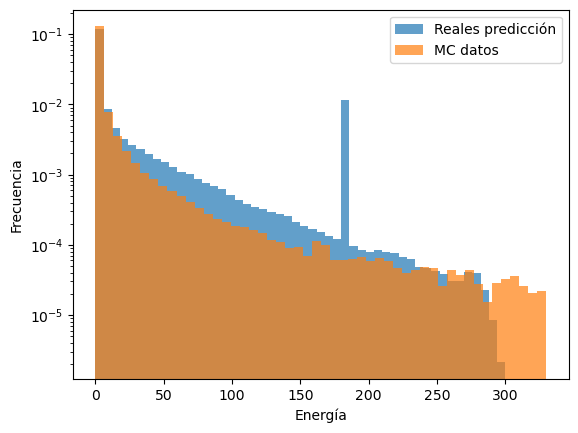

In [10]:
# Representamos como es el espectro de los dos
plt.hist(y_pred, bins=50, density=True, alpha = 0.7, label = "Reales predicción")
plt.hist(y, bins=50, density=True, alpha = 0.7, label = "MC datos")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.legend()
plt.show()

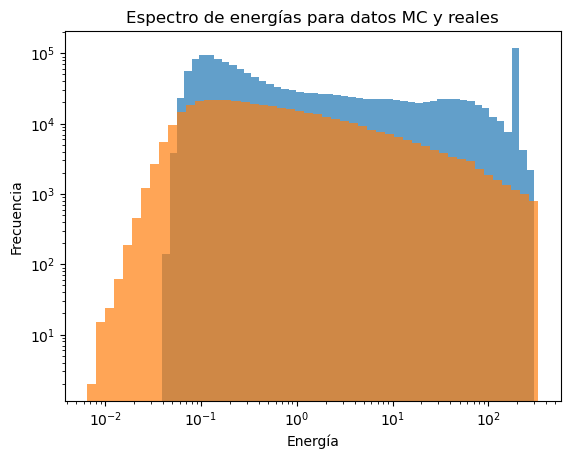

In [39]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]), len(bins))
    plt.hist(x, bins=logbins, alpha = 0.7)

# Representamos como es el espectro de los dos en escala log-log
plot_loghist(y_pred, 50)
plot_loghist(y, 50)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energías para datos MC y reales')
plt.show()

No parece que el problema sea que se simulan con un espectro de energía de E^(-2.0) en vez de E^(-2.7)... aún así lo estudiaremos más adelante

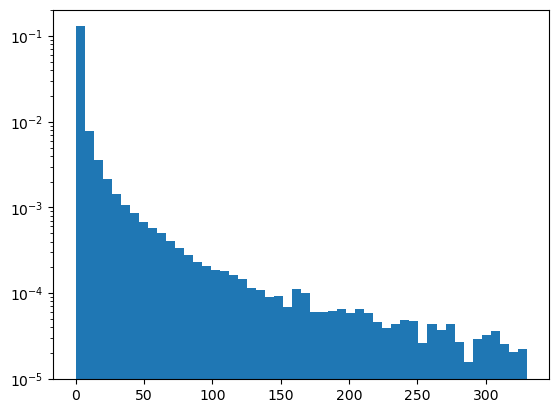

In [25]:
# Representamos ahora como es el espectro de energías simuladas
plt.hist(y, bins=50, density=True)
plt.yscale('log')
plt.show()

Podemos comprobar que el modelo predice de forma bastante razonable el espectro de energías aunque hay un pico alrededor del 180 bastante extraño. Además, estima que las energías caen antes de lo que lo hacen las simulaciones y por lo general da más energía a los sucesos de la que realmente tienen. Vamos a correr el mismo código pero esta vez no habrá un corte de intensidad en los datos.

#### 1.1 RF Regressor de energías sin corte de intensidad

In [35]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=100000)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g2:
    gamma_tel_events2 = loader_g2.read_telescope_events("LST_LST_LSTCam", start=0, stop=20000)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

gamma_tel_events_f = gamma_tel_events[features]
gamma_tel_events_f2 = gamma_tel_events2[features]

# Convertimos a dataframe
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los dataframes
df_gammaT = pd.concat([df_gamma, df_gamma2], axis=0)   

X = df_gamma.drop("true_energy", axis=1)                                              # Determina los parámetros 
y = df_gamma["true_energy"]

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realR = tb[features]
df_realR = df_realR.dropna()

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realR.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

XrealR = df_realR

In [36]:
rf = RandomForestRegressor(n_estimators=125)
rf.fit(X, y)

RandomForestRegressor(n_estimators=125)

In [37]:
# Hacemos predicciones con el modelo:
y_pred = rf.predict(XrealR)

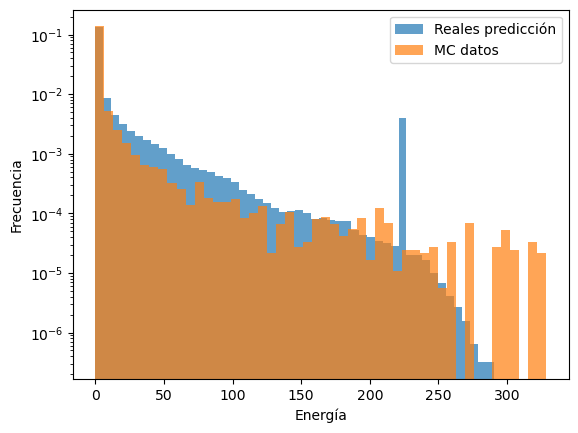

In [38]:
# Representamos ahora como es el espectro de los dos
plt.hist(y_pred, bins=50, density=True, alpha = 0.7, label = "Reales predicción")
plt.hist(y, bins=50, density=True, alpha = 0.7, label = "MC datos")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.legend()
plt.show()

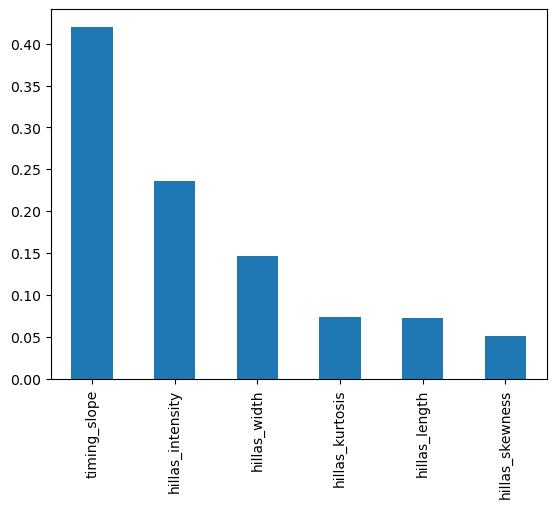

In [43]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

### 2. RF Classifier de gammas y protones entrenado con MC y probado por reales

In [2]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for i2 in range(len(df_protons2)):
    label.append(1)
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
for j2 in range(len(df_gamma2)):
    label.append(0)
    
df_protongamma.insert(6,"label", label, True)

Xc = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
yc = df_protongamma["label"]

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

XrealC = df_realC.drop("gammaness", axis=1)
yrealC = df_realC["gammaness"]

Hay que tener en cuenta dos cosas:
1. Solo podemos usar los mismos parámetros de las imágenes reales que con los que se entrea RF ya que necesita usar los mismos parámetros para MC que para reales para poder compararlos.
2. El corte en intensidad es necesario ya que nuestro RF se entrena con valores por encima de 200 por lo que para valores menores no sabrá etiquetar bien ya que no saben interpolar. Luego igual podemos entrenarlo sin corte de intensidad

Vamos ahora a entrenar un modelo de clasificador con todos los datos de MC y ver cómo nos hace el espectro y tal de los reales. Además, podremos representar la gammaness predicha por la gammaness de las imágenes (supongo que usan un modelo de AA para determinarla) para comparar los resultados.

In [3]:
rfC = RandomForestClassifier(max_depth=19, n_estimators=150)
rfC.fit(Xc, yc)

RandomForestClassifier(max_depth=19, n_estimators=150)

In [4]:
y_pred = (rfC.predict_proba(XrealC))
proba = y_pred[:,0]

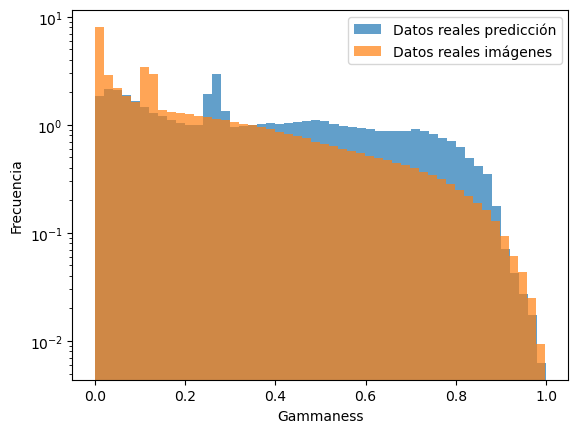

In [5]:
# Representamos ahora cómo es el espectro de las predicciones
plt.hist(proba, bins=50, density=True, alpha = 0.7, label = "Datos reales predicción")
plt.hist(yrealC, bins=50, density=True, alpha = 0.7, label = "Datos reales imágenes")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Gammaness')
plt.legend()
plt.show()

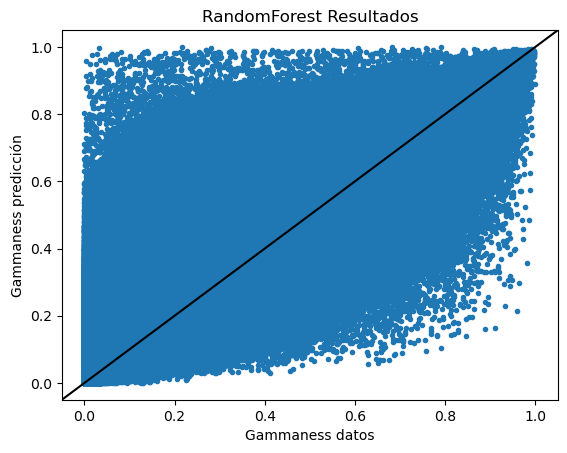

In [6]:
plt.plot(yrealC, proba, ".")
plt.axline((1, 1), slope=1, c="k")

plt.title("RandomForest Resultados")
plt.xlabel('Gammaness datos')
plt.ylabel('Gammaness predicción')

plt.show()

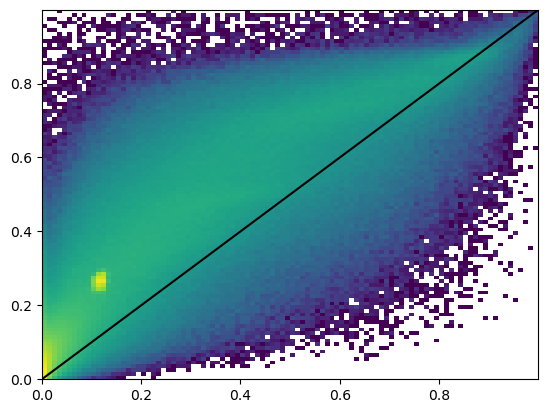

In [11]:
from matplotlib import colors
plt.hist2d(yrealC, proba, bins=100, norm = colors.LogNorm())
plt.axline((1, 1), slope=1, c="k")
plt.show()

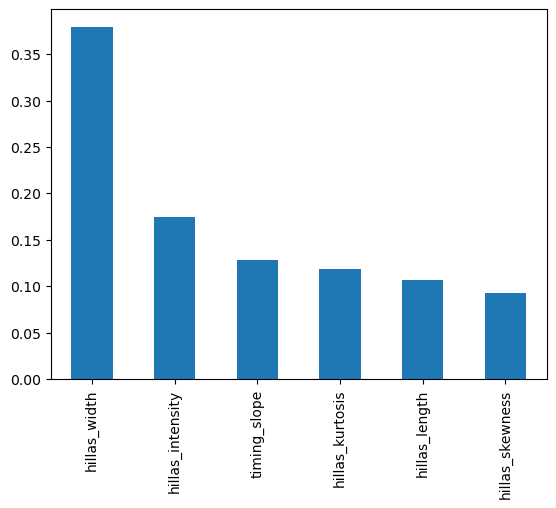

In [8]:
feature_importances = pd.Series(rfC.feature_importances_, index=Xc.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

#### 2.1 RF Classifier de gammas y protones entrenado con MC y probado por reales sin corte de intensidad

Mismo código pero sin corte de intensidad:

In [12]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=500000)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=500000)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=40000)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=30000)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for i2 in range(len(df_protons2)):
    label.append(1)
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
for j2 in range(len(df_gamma2)):
    label.append(0)
    
df_protongamma.insert(6,"label", label, True)

Xc = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
yc = df_protongamma["label"]

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

XrealC = df_realC.drop("gammaness", axis=1)
yrealC = df_realC["gammaness"]

In [13]:
rfC = RandomForestClassifier(max_depth=19, n_estimators=150)
rfC.fit(Xc, yc)

RandomForestClassifier(max_depth=19, n_estimators=150)

In [14]:
y_pred = (rfC.predict_proba(XrealC))
proba = y_pred[:,0]

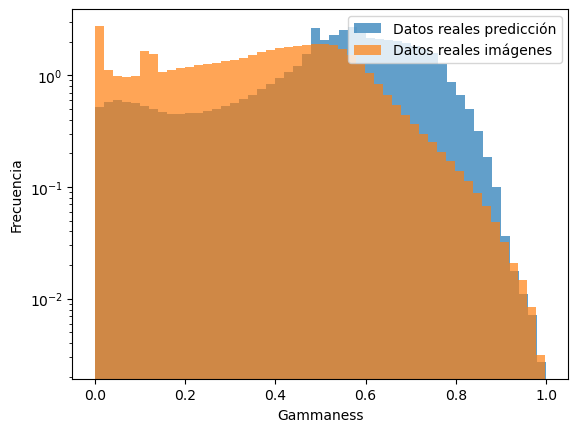

In [15]:
# Representamos ahora cómo es el espectro de las predicciones
plt.hist(proba, bins=50, density=True, alpha = 0.7, label = "Datos reales predicción")
plt.hist(yrealC, bins=50, density=True, alpha = 0.7, label = "Datos reales imágenes")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Gammaness')
plt.legend()
plt.show()

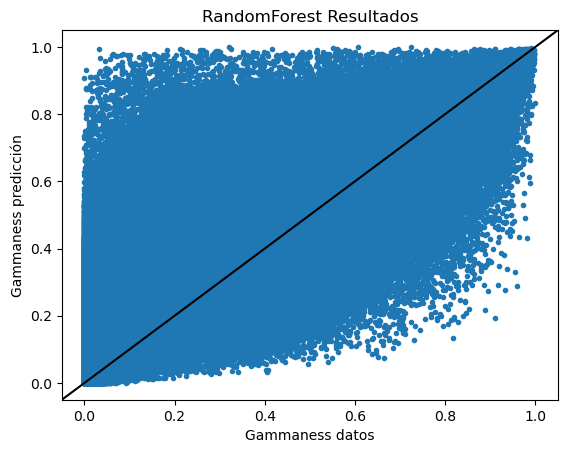

In [16]:
plt.plot(yrealC, proba, ".")
plt.axline((1, 1), slope=1, c="k")

plt.title("RandomForest Resultados")
plt.xlabel('Gammaness datos')
plt.ylabel('Gammaness predicción')

plt.show()

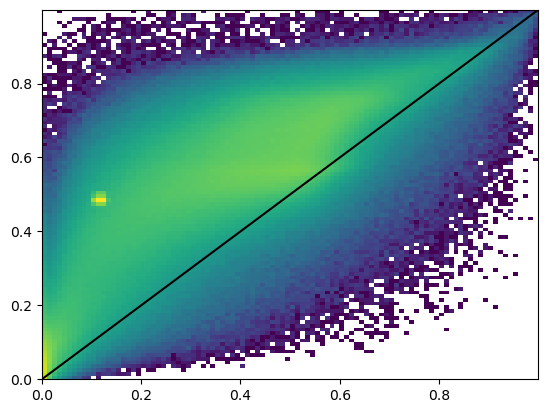

In [17]:
plt.hist2d(yrealC, proba, bins=100, norm = colors.LogNorm())
plt.axline((1, 1), slope=1, c="k")
plt.show()

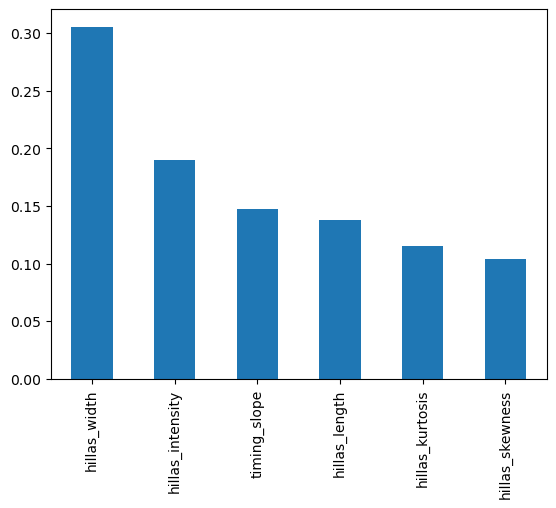

In [18]:
feature_importances = pd.Series(rfC.feature_importances_, index=Xc.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

### 3. RF Classifier de MC y Reales

Ahora vamos a entrenar un modelo de RF clasificador para que, dándole esta vez sucesos reales y aprenda a distinguirlos para así entender qué sucesos simulados son los más puros y por qué y qué sucesos simulados son los más reales y por qué.

In [19]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=500000)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=500000)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=30000)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=30000
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

Ahora entrenamos a nuestro clasificador de reales y simulados                                

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

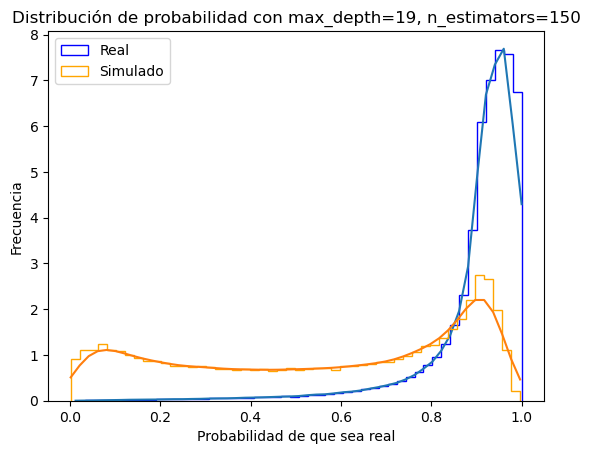

In [21]:
y_pred = (rfrs.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

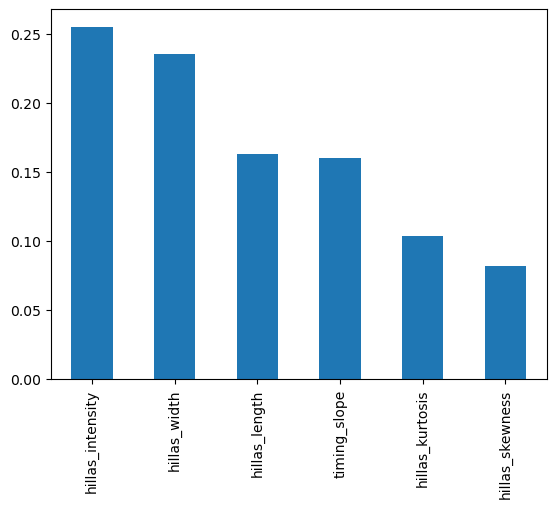

In [22]:
feature_importances = pd.Series(rfrs.feature_importances_, index=X_test.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

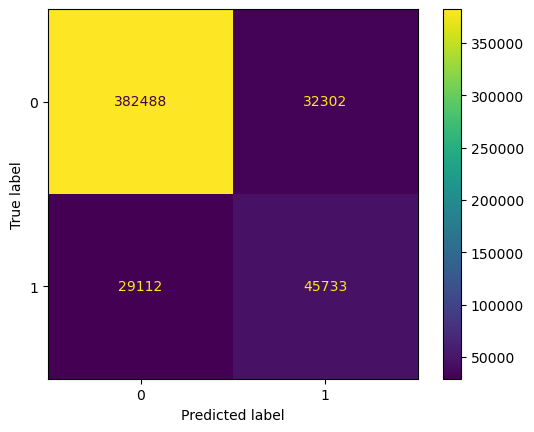

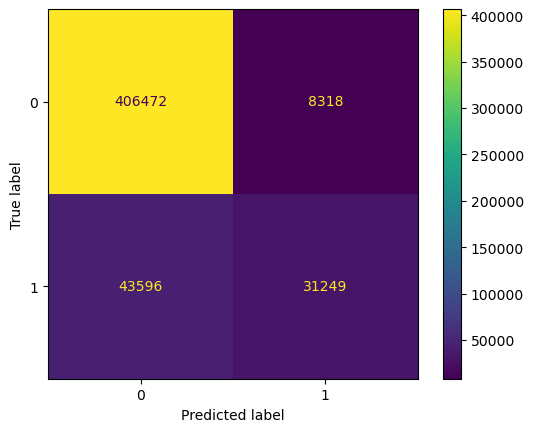

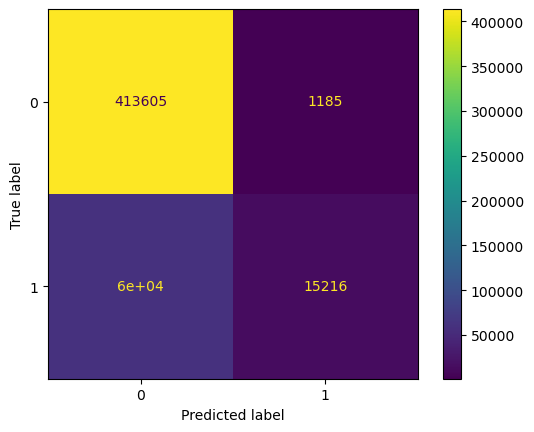

In [23]:
y_pred = (rfrs.predict_proba(X_test)[:,1]>0.25).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.5).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.8).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

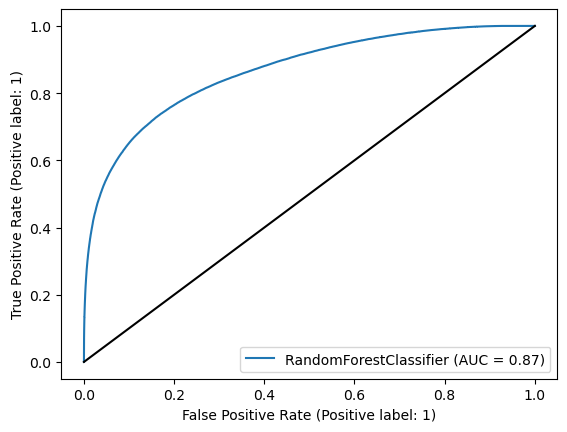

In [27]:
from sklearn.metrics import RocCurveDisplay, auc

# Representamos la curva ROC (para protones y gammas)
ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs, X_test, y_test, ax=ax)

ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.show()

#### 3.1 RF Classifier de MC y Reales sin corte de intensidad

In [28]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=500000)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=500000)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=30000)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=30000
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

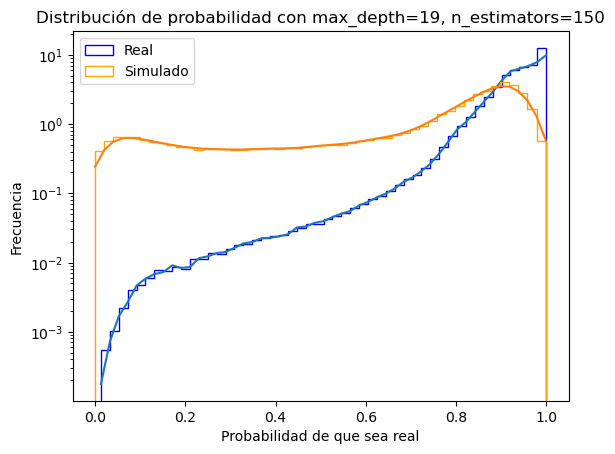

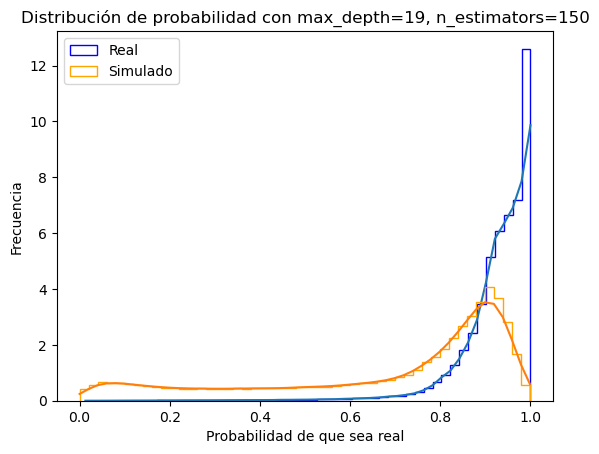

In [31]:
y_pred = (rfrs.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

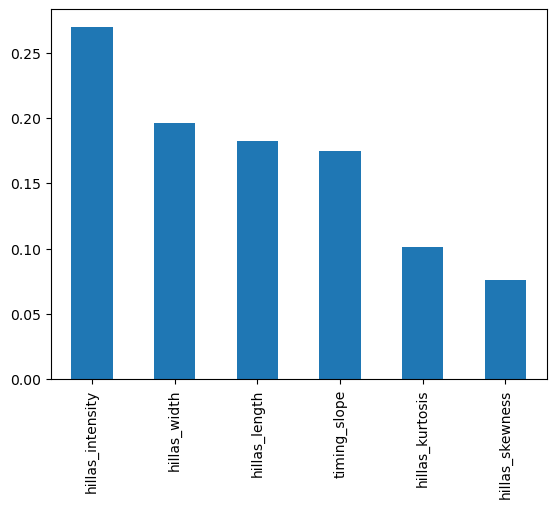

In [32]:
feature_importances = pd.Series(rfrs.feature_importances_, index=X_test.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

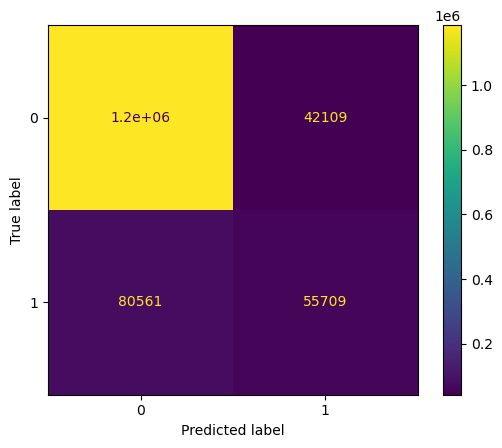

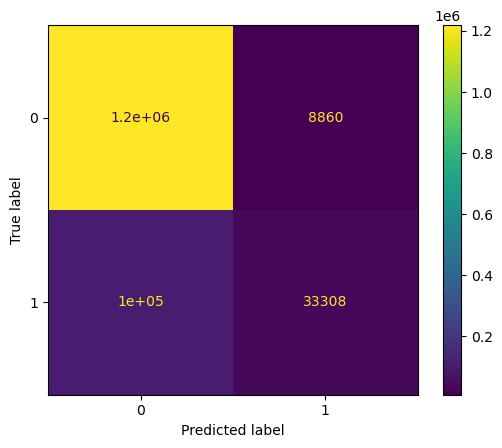

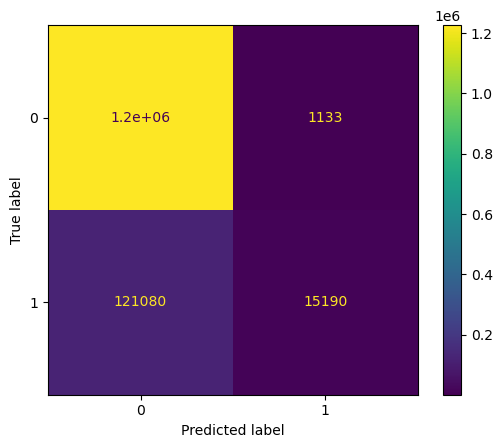

In [33]:
y_pred = (rfrs.predict_proba(X_test)[:,1]>0.25).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.5).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.8).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

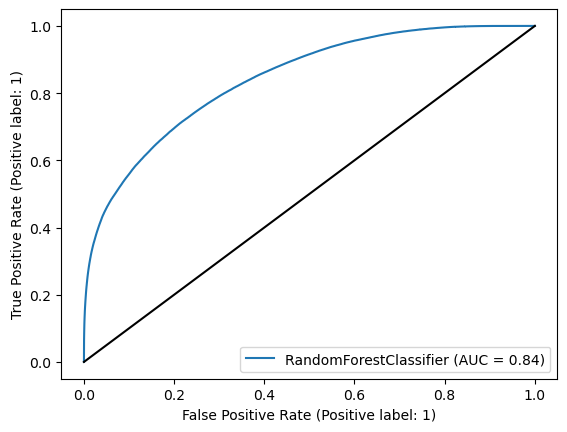

In [34]:
from sklearn.metrics import RocCurveDisplay, auc

# Representamos la curva ROC (para protones y gammas)
ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs, X_test, y_test, ax=ax)

ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.show()

#### 3.2 RF Classifier de MC y Reales con corte de intensidad para todos los datos simulados

Hay varios problemas, el primero es que el pico ya no aparece y me resulta extraño y el segundo es que hay muchos más datos reales que simulados por lo que voy a importar todos los simulados para saber qué tal salen las matrices de confusión ahora:

In [35]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

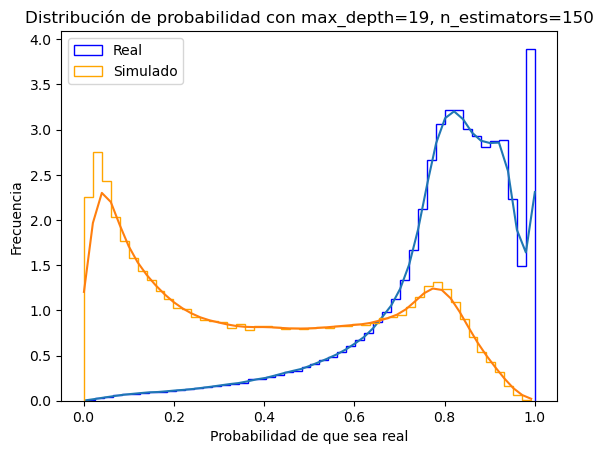

In [37]:
y_pred = (rfrs.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Ahí aparece el pico de super reales y la mayor cantidad de procesos simulados que quería ver.

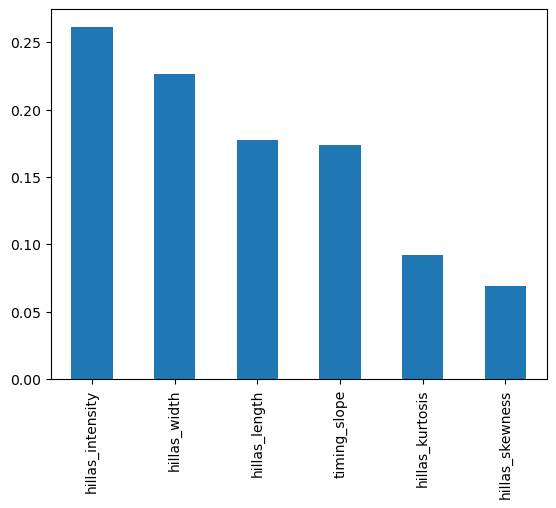

In [38]:
feature_importances = pd.Series(rfrs.feature_importances_, index=X_test.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

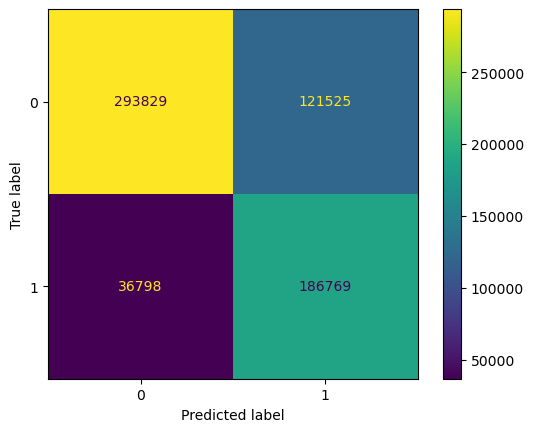

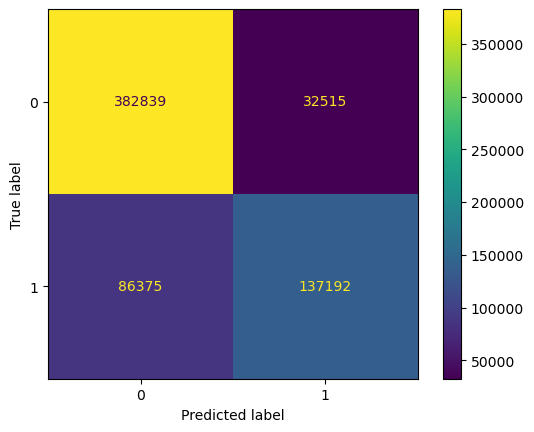

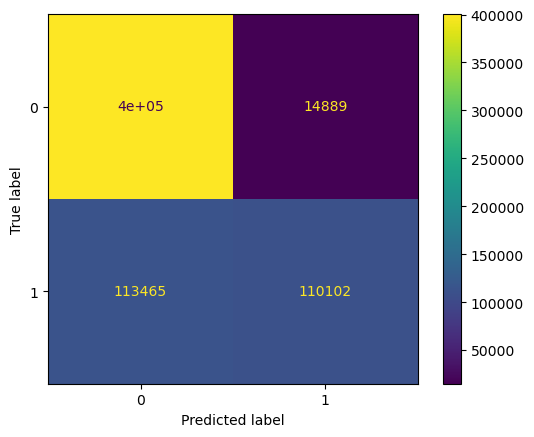

In [39]:
y_pred = (rfrs.predict_proba(X_test)[:,1]>0.25).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.5).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.65).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

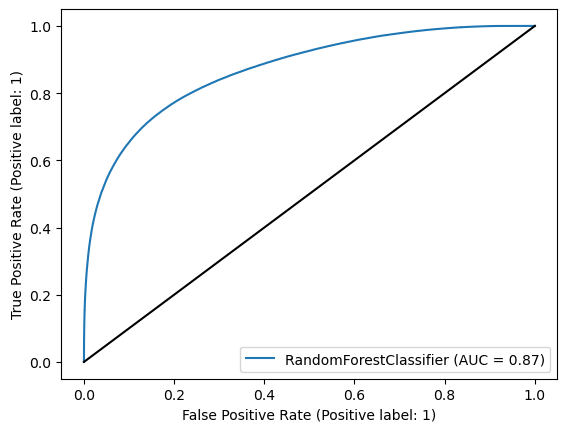

In [40]:
# Representamos la curva ROC (para protones y gammas)
ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs, X_test, y_test, ax=ax)

ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.show()

#### 3.3 RF Classifier de MC y Reales con corte de intensidad para todos los datos simulados

In [42]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfRS = RandomForestClassifier(max_depth=19, n_estimators=150)
rfRS.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

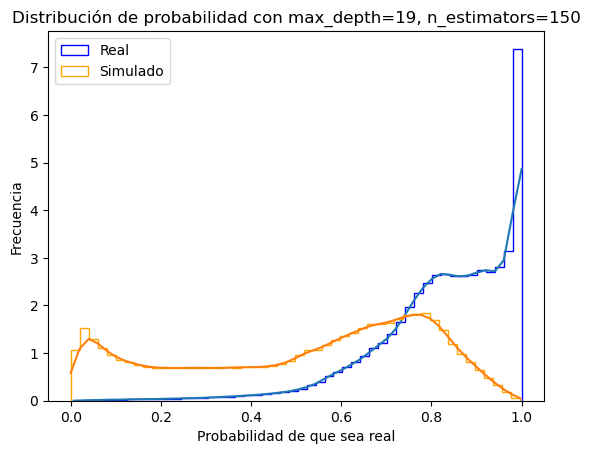

In [44]:
y_pred = (rfRS.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()